In [136]:
import numpy as np
import torch
import trimesh
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# Configurar o uso da GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_point_cloud(file_path):
    """Carrega uma nuvem de pontos a partir de um arquivo .obj"""
    mesh = trimesh.load(file_path)
    return torch.tensor(mesh.vertices, dtype=torch.float32, device=device)

def nearest_neighbor(src, dst, batch_size=4096, max_distance=100000000.0):
    """Encontra pontos correspondentes mais próximos com batching na GPU."""
    
    indices_list = []
    src_filtered_list = []
    
    for i in range(0, src.shape[0], batch_size):
        batch = src[i:i+batch_size]  # Pega um lote de pontos de `src`
        
        # Expande as dimensões para broadcasting eficiente na GPU
        batch_exp = batch.unsqueeze(1)  # [batch_size, 1, 3]
        dst_exp = dst.unsqueeze(0)  # [1, M, 3]

        # Calcula a distância euclidiana para os pontos do batch
        distances = torch.norm(batch_exp - dst_exp, dim=2)  # [batch_size, M]
        
        # Encontra os índices dos vizinhos mais próximos
        min_distances, indices = torch.min(distances, dim=1)  # [batch_size]

        # Filtra pontos muito distantes
        mask = min_distances < max_distance
        indices_filtered = indices[mask].to(torch.int64)  # Converte para int64
        src_filtered = batch[mask]

        # Armazena os resultados
        indices_list.append(indices_filtered)
        src_filtered_list.append(src_filtered)

    # Concatenar todos os batches processados
    if indices_list:
        return torch.cat(indices_list), torch.cat(src_filtered_list)
    else:
        return torch.tensor([], dtype=torch.int64, device=device), torch.tensor([], dtype=torch.float32, device=device)




def compute_transformation(A, B):
    """Computa a matriz de rotação R e translação t que alinha A a B."""
    
    # Centróides das nuvens de pontos
    centroid_A = torch.mean(A, axis=0)
    centroid_B = torch.mean(B, axis=0)
    
    # Centraliza as nuvens de pontos
    A_centered = A - centroid_A
    B_centered = B - centroid_B
    
    # Matriz de covariância
    H = torch.matmul(A_centered.permute(1, 0), B_centered)
    
    # Decomposição SVD
    U, _, Vt = torch.linalg.svd(H)
    R = torch.matmul(Vt.T, U.T)

    # Se a rotação estiver invertida, corrigimos
    if torch.det(R) < 0:
        print("⚠️ Matriz de rotação R invertida, corrigindo...")
        Vt[-1, :] *= -1
        R = torch.matmul(Vt.T, U.T)

    # Calcula a translação
    t = centroid_B - R @ centroid_A

    return R, t


def smooth_transformation(R, t, alpha=1.0):
    """Aplica suavização à transformação para evitar deformações bruscas."""
    R_smoothed = alpha * R + (1 - alpha) * torch.eye(3, device=device)
    t_smoothed = alpha * t
    return R_smoothed, t_smoothed

def icp(A, B, max_iterations=50, tolerance=1e-1):
    """Executa o algoritmo ICP entre duas nuvens de pontos"""
    src = A.clone()
    prev_error = None
    
    for i in range(max_iterations):
        indices, src_filtered = nearest_neighbor(src, B)

        if indices.numel() == 0:  # Se nenhuma correspondência for encontrada
            print("Aviso: Nenhuma correspondência válida encontrada.")
            return torch.eye(3, device=device), torch.zeros(3, device=device)

        B_matched = B[indices]  # Garante que indices não está vazio e tem o mesmo tamanho de src_filtered
        
        if src_filtered.shape[0] != B_matched.shape[0]:  
            print(f"Erro: Tamanhos diferentes - src_filtered {src_filtered.shape} vs B_matched {B_matched.shape}")
            continue  # Pula esta iteração e tenta de novo
        
        R, t = compute_transformation(src_filtered, B_matched)
        R, t = smooth_transformation(R, t)  # Suaviza a transformação antes de aplicá-la

        src_filtered = (R @ src_filtered.T).T + t  # Atualiza src_filtered, não src
        
        mean_error = torch.mean(torch.norm(src_filtered - B_matched, dim=1))
        if prev_error is not None and abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

        print(f"Iterações feitas: {i+1}, Erro final: {mean_error:.6f}")
    
    
    return R, t


def apply_transformation(points, R, t):
    """Aplica uma transformação rígida a uma nuvem de pontos"""
    return (R @ points.T).T + t



In [128]:
# Carregar ground-truth
ground_truth = np.load("ground_truth.npy")

# Carregar os scans
num_scans = 30
point_clouds = [load_point_cloud(f"objetos/KITTI-Sequence/{i:06d}/{i:06d}_points.obj") for i in range(num_scans)]

In [1]:
# Estimar a trajetória
trajectory = np.zeros((num_scans, 3))
T = torch.eye(4, dtype=torch.float32, device=device)

for i in range(1, num_scans):
    R, t = icp(point_clouds[i-1], point_clouds[i])
    
    T_new = torch.eye(4, dtype=torch.float32, device=device)
    T_new[:3, :3] = R
    T_new[:3, 3] = T[:3, :3] @ t + T[:3, 3]  # Aplica a translação relativa corretamente

    T[:3, :3] = R @ T[:3, :3]  # Aplica a rotação corretamente
    T[:3, 3] = T_new[:3, 3]  # Atualiza a translação

    trajectory[i] = T[:3, 3].cpu().numpy()


NameError: name 'np' is not defined

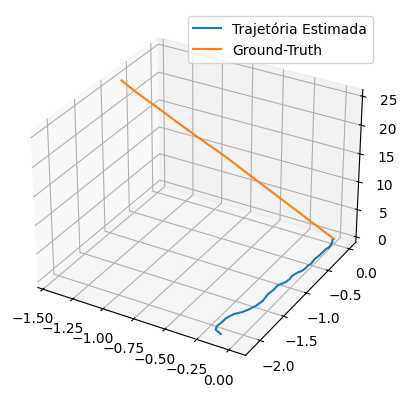

In [116]:
# Plotar a trajetória
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='Trajetória Estimada')
ax.plot(ground_truth[:, 0, 3], ground_truth[:, 1, 3], ground_truth[:, 2, 3], label='Ground-Truth')
ax.legend()
plt.show()